In [1]:
%matplotlib inline

import time 
import datacube
from datacube.utils import masking, geometry 
import sys
import os
import dask 
import rasterio, rasterio.features
import xarray
import glob
import numpy as np
import pandas as pd
import seaborn as sn
import geopandas as gpd
import subprocess as sp
import matplotlib.pyplot as plt
import scipy, scipy.ndimage
import warnings
warnings.filterwarnings("ignore") #this will suppress the warnings for multiple UTM zones in your AOI 

sys.path.append("../Scripts")
from rasterio.mask import mask
from geopandas import GeoSeries, GeoDataFrame
from shapely.geometry import Point
from deafrica_plotting import map_shapefile,display_map, rgb
from deafrica_spatialtools import xr_rasterize
from deafrica_datahandling import wofs_fuser, mostcommon_crs,load_ard,deepcopy
from deafrica_dask import create_local_dask_cluster

#for parallelisation 
from multiprocessing import Pool, Manager
import multiprocessing as mp
from tqdm import tqdm

In [ ]:
path = '../Supplementary_data/Validation/Refined/AFRIGIST/shapefile/groundtruth_AFRIGIST.shp'

In [ ]:
input_data = gpd.read_file(path).to_crs('epsg:6933') #reading the table and converting CRS to metric 
input_data.columns

In [ ]:
coords = [(x,y) for x, y in zip(input_data.geometry.x, input_data.geometry.y)]

In [ ]:
input_data= input_data.drop(['Unnamed_ 0'], axis=1)

### Compare with ESA SCL Band  

In [ ]:
#generate query object 
query ={'group_by':'solar_day',
        'resampling':'nearest'}

In [ ]:
#function to sample WOfS for each validation point for early five days of each month 
def get_wofs_for_point(index, row, input_data, query, results_wet, results_clear):
    dc = datacube.Datacube(app='WOfS_S2SCL')
    #get the month value for each index
    month = input_data.loc[index]['MONTH'] 
    #set the time for query of WOfS database according to the first five days before and after of each calendar month
    timeYM = '2018-'+f'{month:02d}'
    start_date = np.datetime64(timeYM) - np.timedelta64(5,'D')
    end_date = np.datetime64(timeYM) + np.timedelta64(5,'D')
    time = (str(start_date),str(end_date))
    
    plot_id = input_data.loc[index]['PLOT_ID']
    #having the original query as it is 
    dc_query = deepcopy(query) 
    geom = geometry.Geometry(input_data.geometry.values[index].__geo_interface__,  geometry.CRS('EPSG:6933'))
    q = {"geopolygon":geom}
    t = {"time":time} 
    #updating the query
    dc_query.update(t)
    dc_query.update(q)

    ds = dc.load(product ="s2_l2a",
                    y = (input_data.geometry.y[index], input_data.geometry.y[index]),
                    x =(input_data.geometry.x[index], input_data.geometry.x[index]),
                    crs = 'EPSG:6933',
                    time=time,
                    output_crs='EPSG:6933',
                    measurement='SCL'
                    resolution=(-20,20))
    
    #exclude the records that wofl return as empty for water 
    if not ds.SCL == 6:
        pass
    else:
        #Define a mask for wet and clear pixels 
        wet_nocloud = ds.SCL == 6
        #Define a mask for dry and clear pixels 
        dry_nocloud = ds.SCL.isin([2,4,5,7])
        scl_wetnocloud = masking.make_mask(ds, **wet_nocloud).astype(int) 
        scl_drynocloud = masking.make_mask(ds, **dry_nocloud).astype(int)
        clear = (scl_wetnocloud | scl_drynocloud).water.all(dim=['x','y']).values
        n_clear = clear.sum() #record this and use it to filter out month with no valid data 
        if n_clear > 0:
            wet = scl_wetnocloud.isel(time=clear).water.max().values  #record this as WOfS has seen water in the 3*3 window
        else:
            wet = 0 

        results_wet.update({str(int(plot_id))+"_"+str(month) : int(wet)})
        results_clear.update({str(int(plot_id))+"_"+str(month) : int(n_clear)})

In [ ]:
def _parallel_fun(input_data, query, ncpus):
    
    manager = mp.Manager()
    results_wet = manager.dict()
    results_clear = manager.dict()
   
    # progress bar
    pbar = tqdm(total=len(input_data))
        
    def update(*a):
        pbar.update()

    with mp.Pool(ncpus) as pool:
        for index, row in input_data.iterrows():
            pool.apply_async(get_wofs_for_point,
                                 [index,
                                 row,
                                 input_data,
                                 query,
                                 results_wet,
                                 results_clear], callback=update)
        pool.close()
        pool.join()
        pbar.close()
        
    return results_wet, results_clear

In [ ]:
results_wet_test = dict()
results_clear_test = dict()

for index, row in input_data[0:14].iterrows():
    get_wofs_for_point(index, row, input_data, query, results_wet_test, results_clear_test)
    print(time)

In [ ]:
# %%time
wet, clear = _parallel_fun(input_data, query, ncpus=15)

In [ ]:
wetdf = pd.DataFrame.from_dict(wet, orient = 'index')
cleardf = pd.DataFrame.from_dict(clear,orient='index')
df2 = wetdf.merge(cleardf, left_index=True, right_index=True)
df2 = df2.rename(columns={'0_x':'CLASS_WET','0_y':'CLEAR_OBS'})
#split the index (which is plotid+month) into seperate columns
for index, row in df2.iterrows():
    df2.at[index,'PLOT_ID'] = index.split('_')[0] +'.0'
    df2.at[index,'MONTH'] = index.split('_')[1]
#rest the index
df2 = df2.reset_index(drop=True)
#convert plot id and month to str to help with matching
input_data['PLOT_ID'] = input_data.PLOT_ID.astype(str)
input_data['MONTH']= input_data.MONTH.astype(str)
# merge both dataframe at locations where plotid and month match
final_df = pd.merge(input_data, df2, on=['PLOT_ID','MONTH'], how='outer')

In [ ]:
# As water flag more than 1 and also clear observation equal to zero 
indexNames = final_df[(final_df['WATERFLAG'] > 1) | (final_df['CLEAR_OBS'] == 0) | (final_df['CLEAR_OBS'].isna()) ].index 
final_df.drop(indexNames, inplace=True)

In [ ]:
final_df.shape

### Testing on SCL individually

In [16]:
bands = ['blue', 'green', 'red', 'nir', 'SCL']

ds = dc.load(product='s2_l2a',
             measurements=bands,
             dask_chunks={},
             **query)

print(ds)

<xarray.Dataset>
Dimensions:      (time: 18, x: 483, y: 590)
Coordinates:
  * time         (time) datetime64[ns] 2018-01-02T08:53:30 ... 2018-03-28T08:...
  * y            (y) float64 2.843e+06 2.843e+06 ... 2.831e+06 2.831e+06
  * x            (x) float64 2.747e+06 2.747e+06 ... 2.756e+06 2.756e+06
    spatial_ref  int32 6933
Data variables:
    blue         (time, y, x) uint16 dask.array<chunksize=(1, 590, 483), meta=np.ndarray>
    green        (time, y, x) uint16 dask.array<chunksize=(1, 590, 483), meta=np.ndarray>
    red          (time, y, x) uint16 dask.array<chunksize=(1, 590, 483), meta=np.ndarray>
    nir          (time, y, x) uint16 dask.array<chunksize=(1, 590, 483), meta=np.ndarray>
    SCL          (time, y, x) uint8 dask.array<chunksize=(1, 590, 483), meta=np.ndarray>
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref


In [43]:
ds.SCL

<xarray.DataArray 'SCL' (time: 18, y: 590, x: 483)>
dask.array<dc_load_SCL, shape=(18, 590, 483), dtype=uint8, chunksize=(1, 590, 483), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2018-01-02T08:53:30 ... 2018-03-28T08:...
  * y            (y) float64 2.843e+06 2.843e+06 ... 2.831e+06 2.831e+06
  * x            (x) float64 2.747e+06 2.747e+06 ... 2.756e+06 2.756e+06
    spatial_ref  int32 6933
Attributes:
    units:             1
    nodata:            0
    flags_definition:  {'qa': {'bits': [0, 1, 2, 3, 4, 5, 6, 7], 'values': {'...
    crs:               epsg:6933
    grid_mapping:      spatial_ref

In [61]:
dry_nocloud = ds.SCL.isin([2,4,5,7])
dry_nocloud

<xarray.DataArray 'SCL' (time: 18, y: 590, x: 483)>
dask.array<any-aggregate, shape=(18, 590, 483), dtype=bool, chunksize=(1, 590, 483), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2018-01-02T08:53:30 ... 2018-03-28T08:...
  * y            (y) float64 2.843e+06 2.843e+06 ... 2.831e+06 2.831e+06
  * x            (x) float64 2.747e+06 2.747e+06 ... 2.756e+06 2.756e+06
    spatial_ref  int32 6933

In [52]:
#this can be used as a condition 
ds.SCL.attrs['qa'] = 'water'

'6'

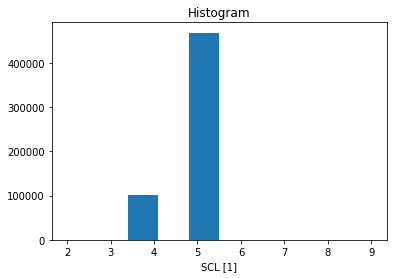

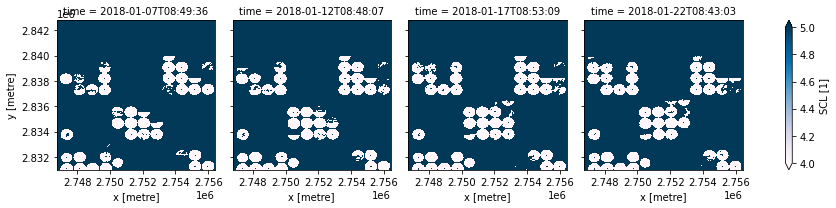

In [58]:
# Plot the SLC results 
ds.SCL.isel(time=slice(1,100,10)).plot()
ds.SCL.isel(time=slice(1,5)).plot(col='time',robust=True,cmap='PuBu')
#ds.SCL.isel(time=slice(0,10)).plot(col='time',robust=True, cmap='PuBu')

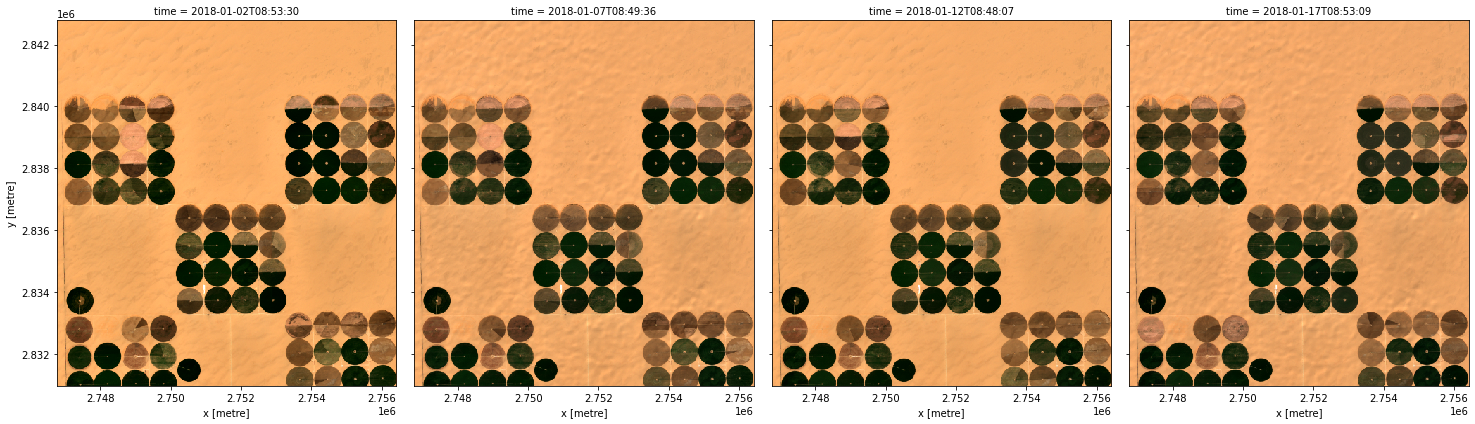

In [57]:
rgb(ds, index=[0,1,2,3])